# Liesel-GAM Demo Notebook

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup and Imports

In [19]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [20]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

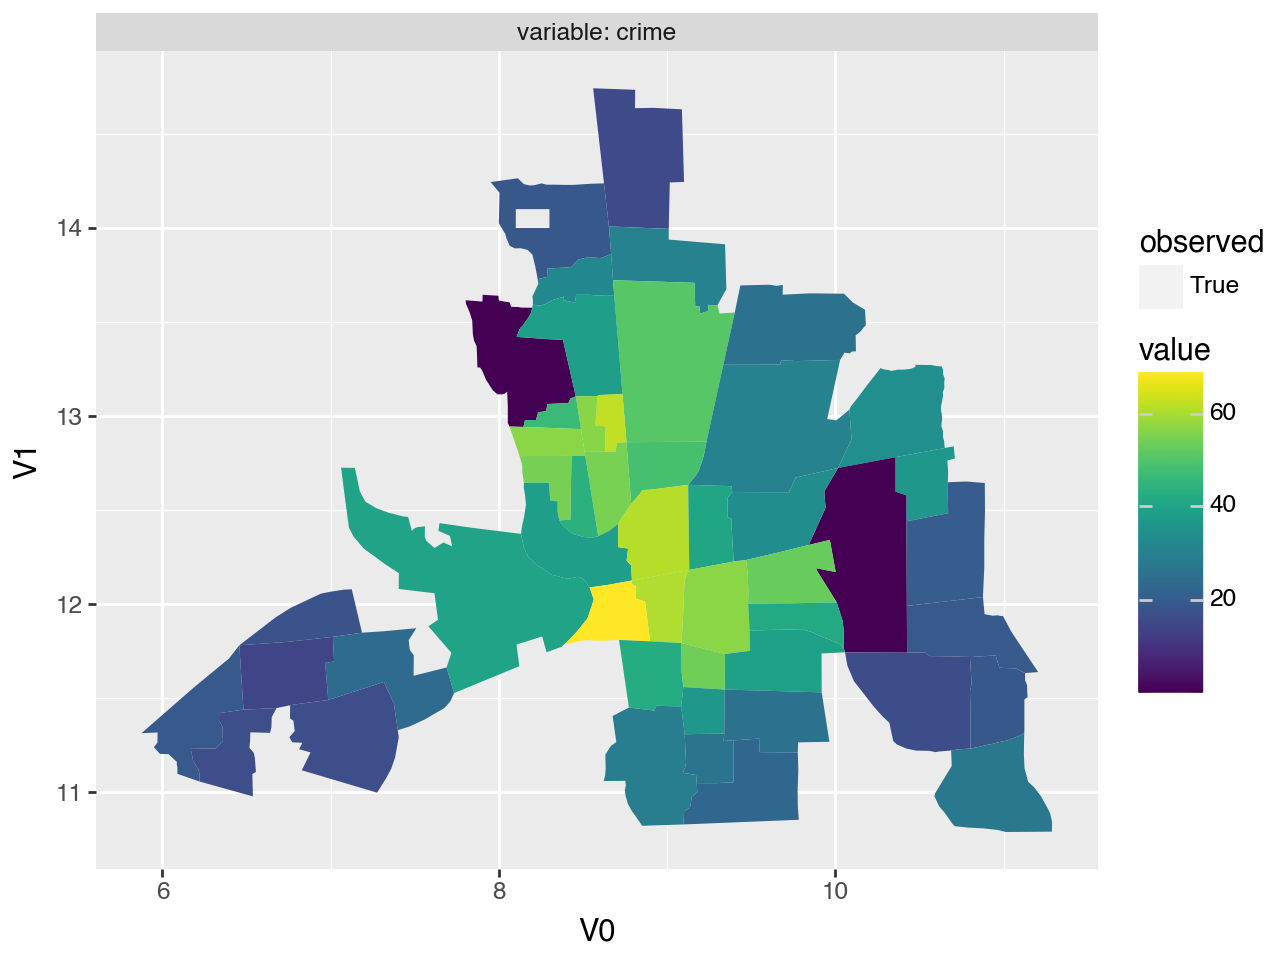

In [21]:
gam.plot_polys(region="district", which=["crime"], df=columb, polys=polys)

## Model Definition

### Setup response model

In [22]:
i = np.arange(columb.shape[0])
i10 = i[:10]
i20 = i[11:20]
i30 = i[21:30]
irest = i[31:]
i = np.concatenate((i10, i20, i30, irest))
df = columb.iloc[i, :].reset_index()

In [23]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

tb = gam.TermBuilder.from_df(df)
loc += tb.mrf("district", polys=polys)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


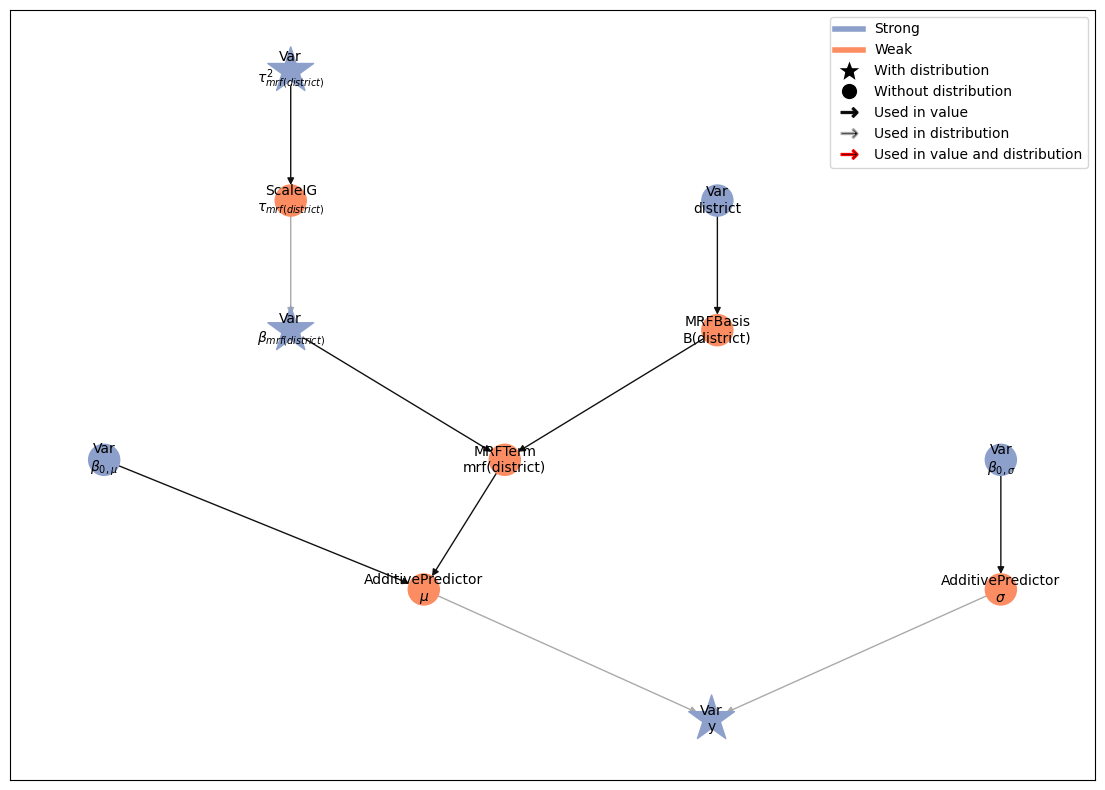

In [24]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [25]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{mrf(district)}$', '$\\tau^2_{mrf(district)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:02<00:00,  6.40chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1333.22chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1548.00chunk/s]
liesel.goose.engine - WARNING - Errors per chain for ker

### MCMC summary

In [26]:
summary = gs.Summary(results)
summary

Parameter summary:

                                   kernel          mean        sd     q_0.05  \
parameter                index                                                 
$\beta_{0,\mu}$          ()     kernel_01  3.477407e+01  2.523327  30.589159   
$\beta_{0,\sigma}$       ()     kernel_00  2.817277e+00  0.106910   2.642684   
$\beta_{mrf(district)}$  (0,)   kernel_02 -2.656994e-03  0.150951  -0.204580   
                         (1,)   kernel_02  1.618971e-04  0.145633  -0.206371   
                         (2,)   kernel_02  1.776101e-03  0.146119  -0.198516   
                         (3,)   kernel_02  1.624400e-03  0.151971  -0.215428   
                         (4,)   kernel_02  3.151708e-04  0.149341  -0.196056   
                         (5,)   kernel_02 -4.333751e-03  0.145975  -0.203641   
                         (6,)   kernel_02 -9.488998e-03  0.156059  -0.228083   
                         (7,)   kernel_02  7.469448e-04  0.139337  -0.199809   
                         (8,)   kernel_02  1.861359e-03  0.146006  -0.200429   
                         (9,)   kernel_02 -1.735993e-03  0.146717  -0.210837   
                         (10,)  kernel_02  9.743934e-03  0.153030  -0.186346   
                         (11,)  kernel_02 -2.365830e-03  0.151159  -0.199851   
                         (12,)  kernel_02  1.770546e-03  0.141188  -0.200903   
                         (13,)  kernel_02 -2.086621e-03  0.138566  -0.206302   
                         (14,)  kernel_02 -6.110893e-04  0.149097  -0.207138   
                         (15,)  kernel_02 -9.299348e-04  0.150982  -0.205132   
                         (16,)  kernel_02  2.533248e-03  0.153565  -0.200462   
                         (17,)  kernel_02  3.852756e-03  0.154426  -0.195277   
                         (18,)  kernel_02 -2.787911e-04  0.155071  -0.213670   
                         (19,)  kernel_02 -2.389007e-03  0.149566  -0.199218   
                         (20,)  kernel_02 -4.739047e-03  0.145500  -0.212611   
                         (21,)  kernel_02 -6.130439e-03  0.139669  -0.202960   
                         (22,)  kernel_02 -7.648793e-04  0.145399  -0.207343   
                         (23,)  kernel_02 -1.788309e-03  0.147018  -0.205825   
                         (24,)  kernel_02  1.395180e-03  0.149226  -0.194372   
                         (25,)  kernel_02  7.534970e-05  0.147349  -0.204972   
                         (26,)  kernel_02  2.549671e-03  0.154599  -0.200887   
                         (27,)  kernel_02 -3.754122e-03  0.150704  -0.215493   
                         (28,)  kernel_02 -3.505154e-03  0.145670  -0.203149   
                         (29,)  kernel_02  2.535636e-04  0.147743  -0.209690   
                         (30,)  kernel_02 -5.294917e-03  0.139813  -0.210077   
                         (31,)  kernel_02 -8.157766e-04  0.146088  -0.209538   
                         (32,)  kernel_02  1.935177e-03  0.144852  -0.198205   
                         (33,)  kernel_02  2.847421e-03  0.150783  -0.198712   
                         (34,)  kernel_02 -1.977808e-03  0.138660  -0.197446   
                         (35,)  kernel_02  4.145150e-03  0.141530  -0.188889   
                         (36,)  kernel_02 -6.272741e-03  0.140504  -0.212426   
                         (37,)  kernel_02 -3.429293e-04  0.147848  -0.215924   
                         (38,)  kernel_02  3.472372e-03  0.149018  -0.202688   
                         (39,)  kernel_02 -9.193662e-07  0.146165  -0.203358   
                         (40,)  kernel_02  5.577367e-03  0.149781  -0.191469   
                         (41,)  kernel_02  3.931856e-03  0.154669  -0.201827   
                         (42,)  kernel_02 -9.563955e-03  0.148010  -0.215100   
                         (43,)  kernel_02 -8.749099e-03  0.146586  -0.220619   
                         (44,)  kernel_02  1.985641e-02  0.153552  -0.175506   
                         (45,)  kernel_02 -2.501485e-02  0.1

## Plots

In [27]:
samples = results.get_posterior_samples()

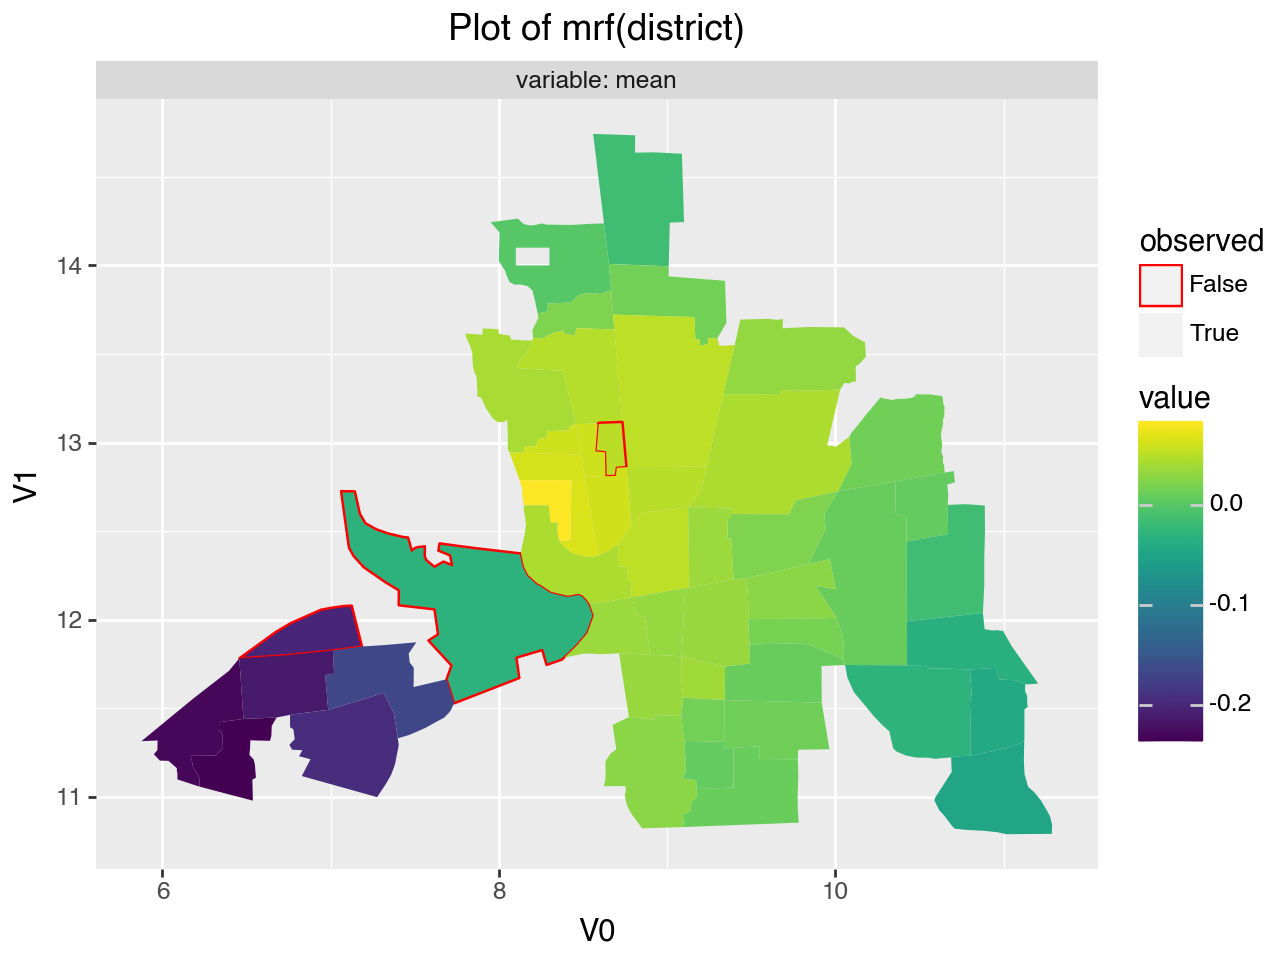

In [28]:
gam.plot_regions(term=loc.terms["mrf(district)"], samples=samples, polys=polys)

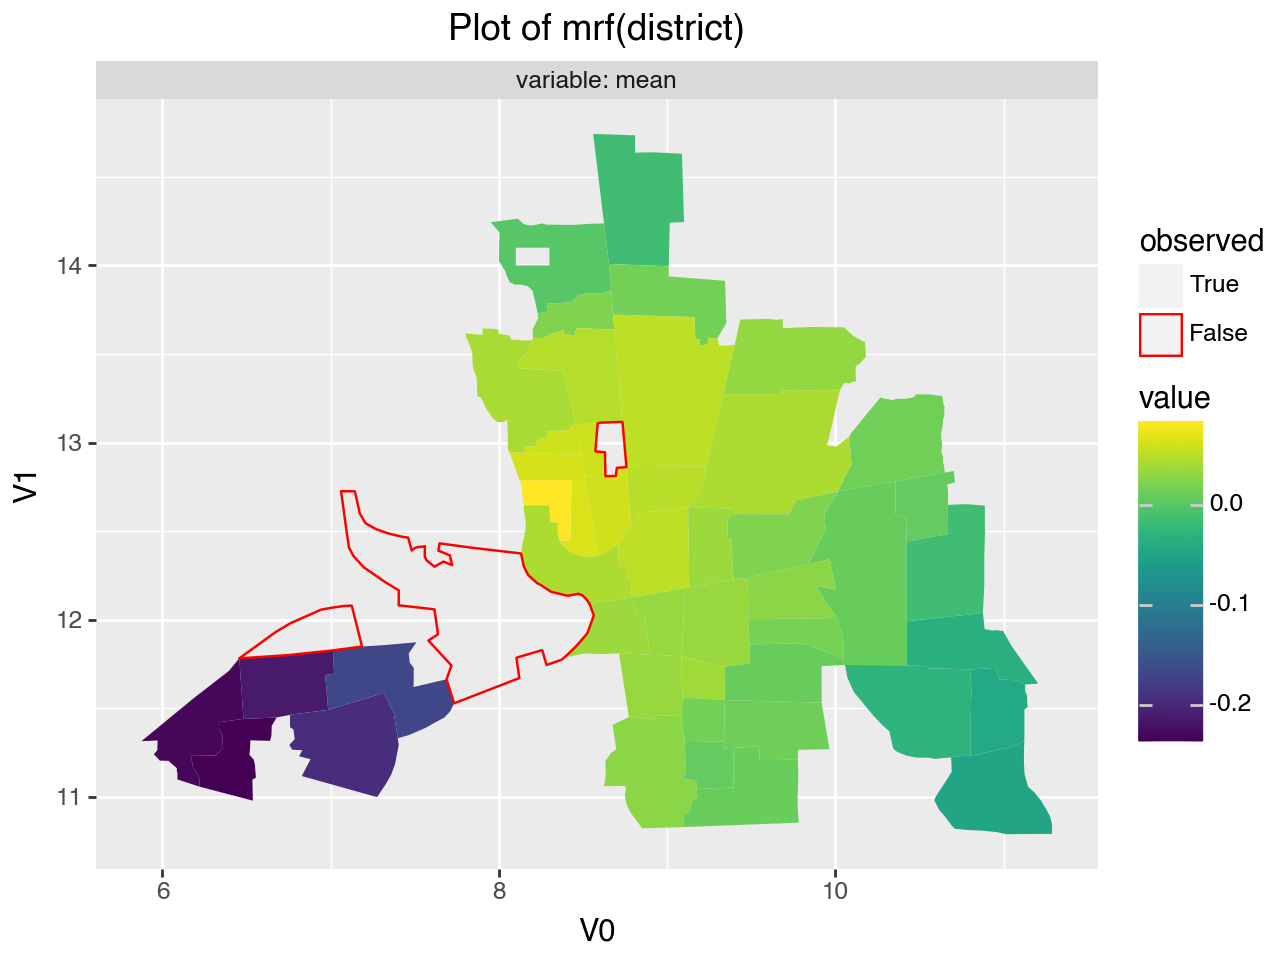

In [29]:
gam.plot_regions(
    term=loc.terms["mrf(district)"],
    samples=samples,
    polys=polys,
    show_unobserved=False,
    unobserved_color="red",
    observed_color="none",
)

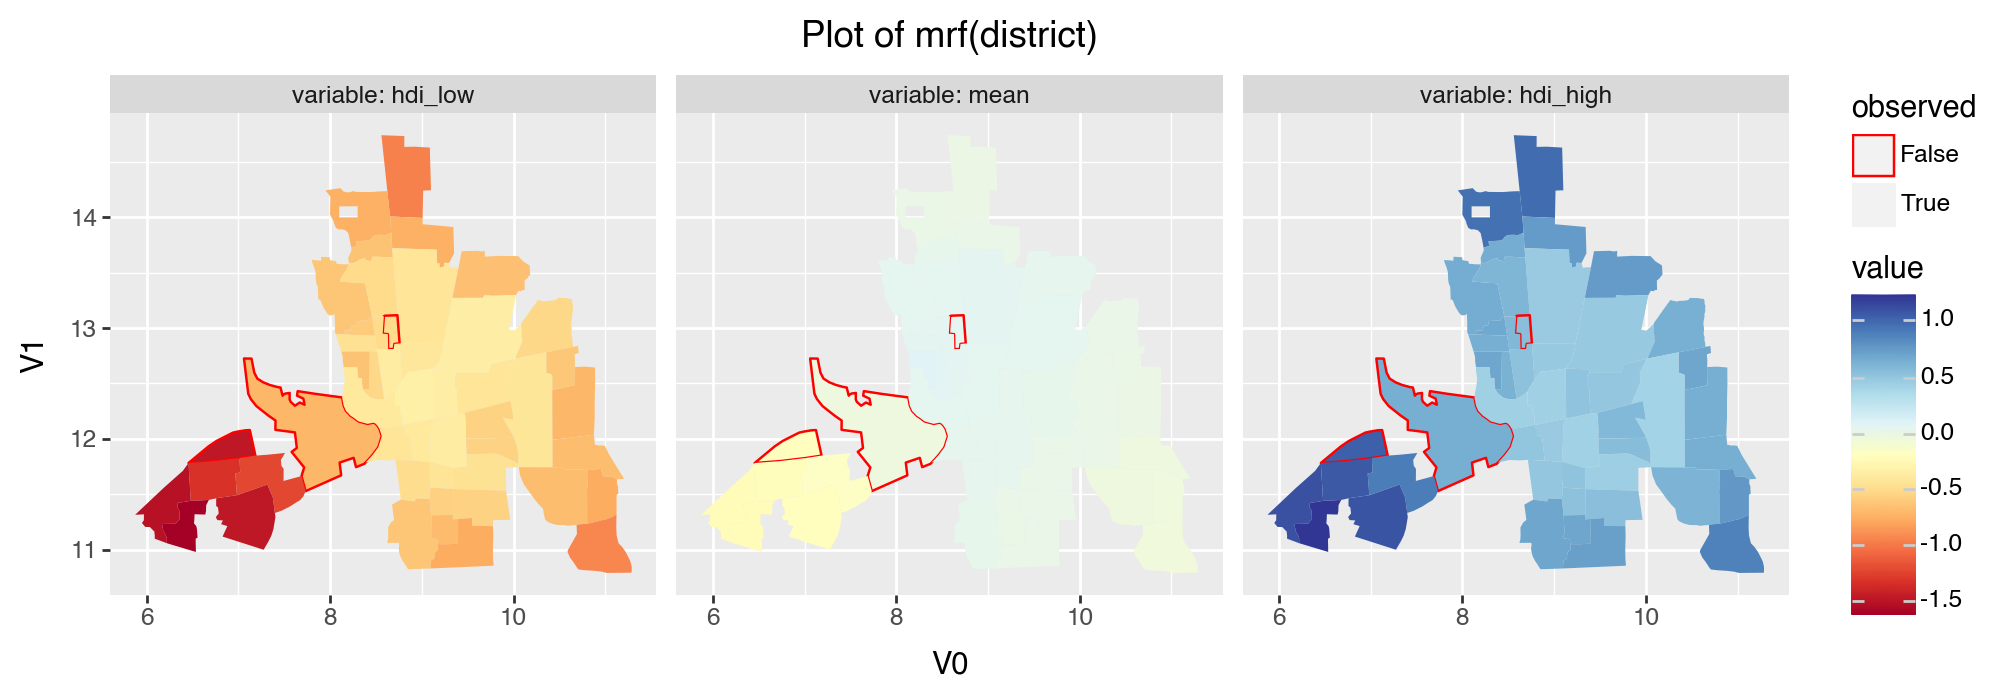

In [30]:
import plotnine as p9

(
    gam.plot_regions(
        term=loc.terms["mrf(district)"],
        samples=samples,
        polys=polys,
        which=["hdi_low", "mean", "hdi_high"],
        observed_color="none",
        unobserved_color="red",
        # show_unobserved=False
    )
    + p9.theme(figure_size=(10, 3.5))
    + p9.scale_fill_cmap("RdYlBu")
)

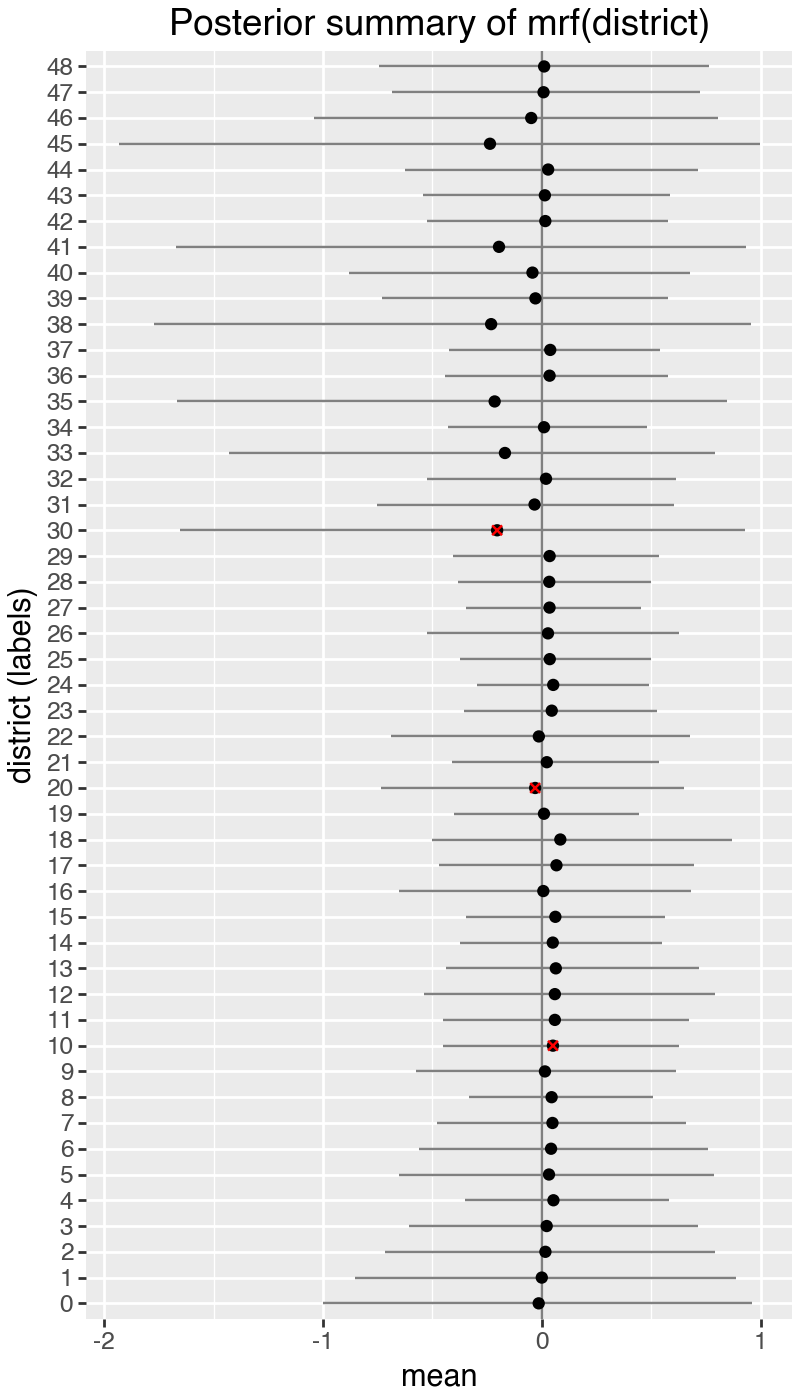

In [31]:
gam.plot_forest(
    term=loc.terms["mrf(district)"],
    samples=samples,
    ymin="q_0.05",
    ymax="q_0.95",
    show_unobserved=True,
) + p9.theme(figure_size=(4, 7))